In this notebook, we will be creating a simple model to predict Benignness or Malignancy given breast cancer data. Before beginning, let us create a virtual environment and import the required libraries.

## Loading the environment

In [143]:
!python -m venv .venv
!.\.venv\Scripts\python.exe -m pip install --upgrade pip numpy pandas seaborn ipykernel scikit-learn
!.\.venv\Scripts\python.exe -m ipykernel install --user --name=.venv --display-name "Python (.venv)"

Error: [Errno 13] Permission denied: 'c:\\Users\\Admin\\Documents\\Personal\\Data-Cleaning-Activity\\.venv\\Scripts\\python.exe'


Installed kernelspec .venv in C:\Users\Admin\AppData\Roaming\jupyter\kernels\.venv


## Dataset Analysis

Let's load the dataset so that we can use it later in the code.
We'll also display basic information about the dataset to confirm that we've done it correctly.

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Load the dataset
df = pd.read_csv('wdbc.csv')

# Display dataset shape
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

print("\nColumn names:")
print(df.columns.tolist())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

Dataset shape: (569, 32)

First few rows:
         ID Diagnosis  radius1  texture1  perimeter1   area1  smoothness1  \
0    842302         M    17.99     10.38      122.80  1001.0      0.11840   
1    842517         M    20.57     17.77      132.90  1326.0      0.08474   
2  84300903         M    19.69     21.25      130.00  1203.0      0.10960   
3  84348301         M    11.42     20.38       77.58   386.1      0.14250   
4  84358402         M    20.29     14.34      135.10  1297.0      0.10030   

   compactness1  concavity1  concave_points1  ...  radius3  texture3  \
0       0.27760      0.3001          0.14710  ...    25.38     17.33   
1       0.07864      0.0869          0.07017  ...    24.99     23.41   
2       0.15990      0.1974          0.12790  ...    23.57     25.53   
3       0.28390      0.2414          0.10520  ...    14.91     26.50   
4       0.13280      0.1980          0.10430  ...    22.54     16.67   

   perimeter3   area3  smoothness3  compactness3  concavity3  

Our dataset appears complete.
Let's run a quick analysis before creating the model.
Since we're given two input nodes to work with, we'll have to identify the best columns to represent the whole dataset.

In [145]:
# Check the data structure
print("Dataset info:")
print(df.info())

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  569 non-null    int64  
 1   Diagnosis           569 non-null    object 
 2   radius1             569 non-null    float64
 3   texture1            569 non-null    float64
 4   perimeter1          569 non-null    float64
 5   area1               569 non-null    float64
 6   smoothness1         569 non-null    float64
 7   compactness1        569 non-null    float64
 8   concavity1          569 non-null    float64
 9   concave_points1     569 non-null    float64
 10  symmetry1           569 non-null    float64
 11  fractal_dimension1  569 non-null    float64
 12  radius2             569 non-null    float64
 13  texture2            569 non-null    float64
 14  perimeter2          569 non-null    float64
 15  area2               569 non-null    float64

In [146]:
# Separate features from target, Since the first column is ID and the second is Diagnosis
X = df.iloc[:, 2:]  # Features
y = df.iloc[:, 1]   # Diagnosis

print(f"\nFeatures shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")


Features shape: (569, 30)
Target distribution:
Diagnosis
B    357
M    212
Name: count, dtype: int64


Top 10 features most correlated with diagnosis:
concave_points3    0.793566
perimeter3         0.782914
concave_points1    0.776614
radius3            0.776454
perimeter1         0.742636
area3              0.733825
radius1            0.730029
area1              0.708984
concavity1         0.696360
concavity3         0.659610
dtype: float64


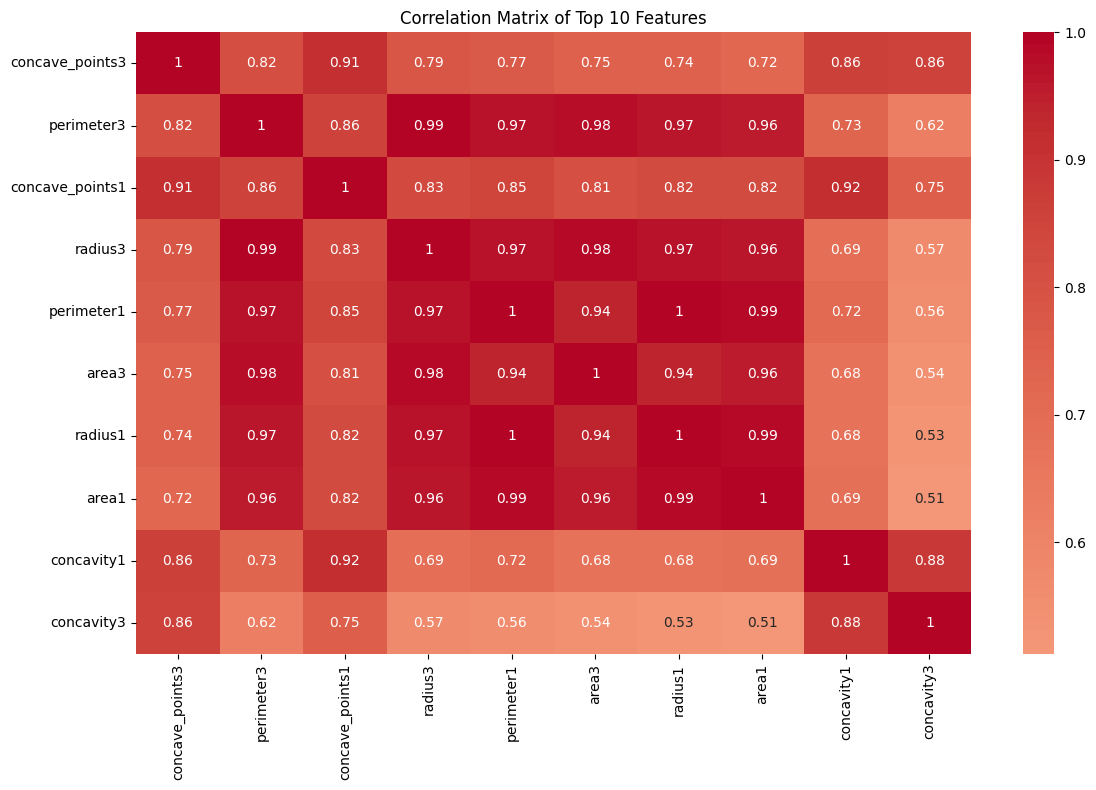

In [147]:
# Here, we will analyze feature importance using correlation matrix

# Convert diagnosis to binary for correlation analysis
y_binary = (y == 'M').astype(int)  # M=Malignant, B=Benign

# Calculate correlation with target
correlations_with_target = X.corrwith(y_binary).abs().sort_values(ascending=False)

print("Top 10 features most correlated with diagnosis:")
print(correlations_with_target.head(10))

# Plot correlation heatmap for top correlated features
plt.figure(figsize=(12, 8))
top_features = correlations_with_target.head(10).index
corr_matrix = X[top_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Top 10 Features')
plt.tight_layout()
plt.show()


Let's also look at variance and clustering potential.


Top features by ANOVA F-score:
            feature     f_score  correlation
27  concave_points3  964.385393     0.012838
22       perimeter3  897.944219     0.323872
7   concave_points1  861.676020     0.708984
20          radius3  860.781707     0.358560
2        perimeter1  697.235272     0.776614
23            area3  661.600206     0.292999
0           radius1  646.981021     0.793566
3             area1  573.060747     0.776454
6        concavity1  533.793126     0.730029
26       concavity3  436.691939     0.067016


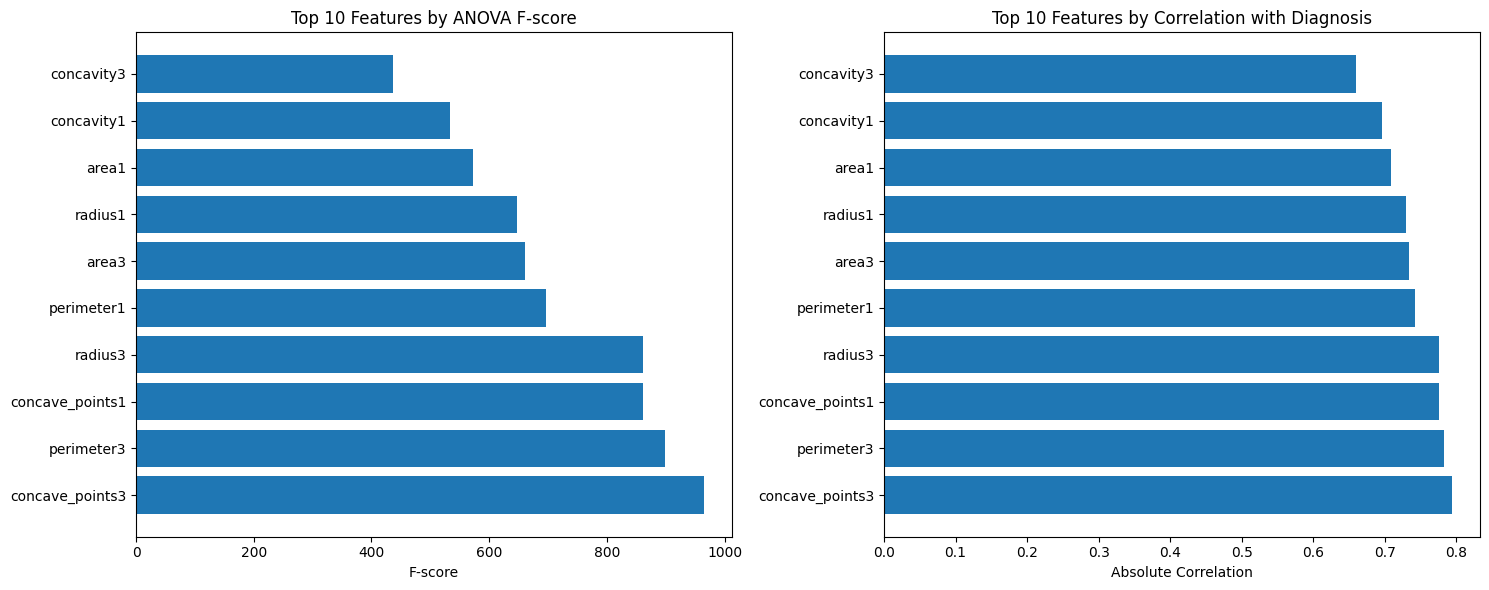

In [148]:
# Analyze feature variance and separation
from sklearn.feature_selection import SelectKBest, f_classif

# The ANOVA F-value is a statistical test statistic that represents the ratio of the variance between groups to the variance within groups.
# We'll look for the features with the highest F-values.
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X, y_binary)

feature_scores = pd.DataFrame({
    'feature': X.columns,
    'f_score': selector.scores_,
    'correlation': correlations_with_target.values
}).sort_values('f_score', ascending=False)

print("\nTop features by ANOVA F-score:")
print(feature_scores.head(10))

# Visualize the top features
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot top F-scores
top_f = feature_scores.head(10)
ax1.barh(top_f['feature'], top_f['f_score'])
ax1.set_title('Top 10 Features by ANOVA F-score')
ax1.set_xlabel('F-score')

# Plot top correlations
top_corr = correlations_with_target.head(10)
ax2.barh(top_corr.index, top_corr.values)
ax2.set_title('Top 10 Features by Correlation with Diagnosis')
ax2.set_xlabel('Absolute Correlation')

plt.tight_layout()
plt.show()

With **perimeter3** and **concave_points3** having both the highest correlation and clustering potential, these will be our top two candidates.

## Building the Model

In [149]:
# We need numeric arrays for training
# So we'll standardize (zero-mean, unit-std)
# because gradient descent behaves much better when features are on similar scales.

from sklearn.model_selection import train_test_split


features = ["concave_points3","perimeter3"] 
target = "Diagnosis"
mapping = {'M': 1, 'B': 0}

X = df[features].values.astype(float)

df['target_num'] = df[target].map(mapping)
y = df['target_num'].values.reshape(-1,1).astype(float)

# let's split the data into training and test sets, as to keep test set untouched for final evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

# further split training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=42)

# To standardize the dataset, we fit scaler on training set only to prevent leakage of test stats into training.
# This makes learning stable and comparable between features.
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test  = scaler.transform(X_test)
X_val   = scaler.transform(X_val)  

print("Shapes — X_train:", X_train.shape, "X_test:", X_test.shape)

Shapes — X_train: (341, 2) X_test: (114, 2)


Below is a simple model architecture for a 2-layer neural network.

In [150]:
# HELPER FUNCTIONS

import numpy as np

def sigmoid(z):
    # The sigmoid activation function squashes real numbers into the intertval (0,1)
    # serves as bounded hidden activation for forward propagation
    # and also as output activation for binary classification
    return 1.0 / (1.0 + np.exp(-z))

def dsigmoid(a):
    # Used in backpropagation
    return a * (1.0 - a)

def binary_cross_entropy(y_true, y_pred):
    # compute the average binary cross-entropy loss over the batch
    # np.log(0) is undefined and causes -inf. The eps clip ensures stable computation.
    eps = 1e-9
    y_pred = np.clip(y_pred, eps, 1 - eps)
    m = y_true.shape[0]
    return - (1.0 / m) * np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

In [151]:
# NEURON CLASS
# Each neuron stores its own weights and biases and exposes forward/backward/update methods.
# Neuron.forward accepts X (batch, n_in) and returns (batch, 1).
# Neuron.backward accepts dZ (batch,) -> derivative wrt pre-activation z, returns (dW, db, dA_prev).

class Neuron:
    def __init__(self, n_in, seed=None, scale=0.1):
        self.n_in = n_in
        rng = np.random.RandomState(seed)
        self.w = rng.randn(n_in) * scale   # shape (n_in,)
        self.b = 0.0                       # scalar bias
        # caches used for backward
        self._last_X = None                # shape (m, n_in)
        self._last_a = None                # shape (m, ) or (m,1) flattened

    def forward(self, X):
        """
        X: (m, n_in)
        returns: a (m, 1)
        """
        z = X.dot(self.w) + self.b          # (m,)
        a = sigmoid(z)                      # (m,)
        # store for backprop (keep shapes convenient)
        self._last_X = X
        self._last_a = a
        return a.reshape(-1, 1)             # return column vector (m,1)

    def backward(self, dZ):
        """
        dZ: (m,) or (m,1) representing dL/dz for this neuron across the batch
        returns: (dW: (n_in,), db: scalar, dA_prev: (m, n_in))
        Why: Neuron computes its own gradient contributions.
        """
        if dZ.ndim == 2:
            dZ = dZ.ravel()
        X = self._last_X                    # (m, n_in)
        m = X.shape[0]
        # gradients
        # dW = X.T dot dZ  -> (n_in,)
        dW = X.T.dot(dZ)                    # (n_in,)
        db = np.sum(dZ)                     # scalar
        # derivative w.r.t inputs (to pass to previous layer)
        # dA_prev = dZ[:,None] dot w[None,:] -> (m, n_in)
        dA_prev = np.outer(dZ, self.w)      # (m, n_in)
        return dW / 1.0, db / 1.0, dA_prev  # division by 1 kept for clarity (no avg here)

    def update_params(self, dW, db, lr):
        # simple SGD step
        self.w -= lr * dW
        self.b -= lr * db


In [152]:
# LAYER CLASS
# a Layer is a collection of neurons.
# Layer.forward returns (m, n_neurons). Layer.backward takes dZ matrix (m, n_neurons)
# and returns dA_prev (m, n_inputs) and collects grads for updates.

class Layer:
    def __init__(self, n_in, n_neurons, seed=None, scale=0.1):
        self.n_in = n_in
        self.n_neurons = n_neurons
        # create individual neurons with different seeds for reproducibility
        base = seed if seed is not None else 0
        self.neurons = [Neuron(n_in, seed=(base + i), scale=scale) for i in range(n_neurons)]

    def forward(self, X):
        # For each neuron forward, stack outputs horizontally
        cols = [neuron.forward(X) for neuron in self.neurons]   # list of (m,1)
        return np.hstack(cols)                                  # (m, n_neurons)

    def backward(self, dZ):
        """
        dZ: (m, n_neurons) - derivative wrt each neuron pre-activation
        returns:
           grads: list of (dW, db) for each neuron (dW shape (n_in,), db scalar)
           dA_prev: (m, n_in) derivative to pass back to previous layer
        """
        m = dZ.shape[0]
        dA_prev_total = np.zeros((m, self.n_in))
        grads = []
        for j, neuron in enumerate(self.neurons):
            dZj = dZ[:, j]                    # shape (m,)
            dWj, dbj, dA_prev_j = neuron.backward(dZj)
            grads.append((dWj, dbj))
            dA_prev_total += dA_prev_j        # accumulate contributions across neurons
        return grads, dA_prev_total

    def update_params(self, grads, lr):
        # grads is list of (dW, db) in same order as neurons
        for neuron, (dW, db) in zip(self.neurons, grads):
            neuron.update_params(dW, db, lr)

In [153]:
# NEURAL NETWORK CLASS
# Holds structure and training logic
# Stacks layers and performs training

import copy

class NeuralNet:
    def __init__(self, layer_sizes, seed=1, scale=0.1):
        """
        layer_sizes: list like [n_input, n_hidden, ..., n_output]
        e.g. [2, 4, 1]
        """
        self.layer_sizes = layer_sizes
        self.layers = []
        for i in range(len(layer_sizes) - 1):
            n_in = layer_sizes[i]
            n_out = layer_sizes[i+1]
            self.layers.append(Layer(n_in, n_out, seed=seed + i, scale=scale))

    def forward(self, X):
        A = X
        caches = []
        for layer in self.layers:
            A = layer.forward(A)   # each layer.forward expects (m, n_in) and returns (m, n_out)
            caches.append(A)       # caches hold activations per layer (post-activation)
        return A, caches          # final A is output probabilities if last activation is sigmoid

    def predict(self, X, threshold=0.5):
        probs, _ = self.forward(X)
        preds = (probs >= threshold).astype(int)
        return preds, probs

    def train(self, X_train, y_train, X_val, y_val, epochs=1000, lr0=0.8, decay=0.996, print_every=100):

        history = {'loss':[], 'val_loss':[], 'acc':[], 'val_acc':[], 'lr':[]}

        # minimal checkpointing: remember best layers by val_loss
        best_val_loss = float('inf')
        best_layers = copy.deepcopy(self.layers)

        best_val = float('inf')
        best_state = None 

        for epoch in range(1, epochs+1):
            lr = lr0 * (decay ** epoch)
            # ---- forward ----
            A_out, caches = self.forward(X_train)
            loss = binary_cross_entropy(y_train, A_out)

            # ---- backward ----
            m = y_train.shape[0]
            # output layer dZ simplification for BCE + sigmoid: dZ = (A - y) / m
            dZ = (A_out - y_train) / m 
            # backprop through last layer
            grads_list, dA_prev = self.layers[-1].backward(dZ)
            # update last layer params
            self.layers[-1].update_params(grads_list, lr)

            # propagate backwards through earlier layers
            for layer_idx in range(len(self.layers)-2, -1, -1):
                a = caches[layer_idx]               # activation after this layer (m, n_neurons)
                dZ_hidden = dA_prev * dsigmoid(a)   # elementwise multiply, shape (m, n_neurons)
                grads_list, dA_prev = self.layers[layer_idx].backward(dZ_hidden)
                self.layers[layer_idx].update_params(grads_list, lr)

            # ---- validation metrics ----
            A_val, _ = self.forward(X_val)
            val_loss = binary_cross_entropy(y_val, A_val)
            if val_loss < best_val:
                best_val = val_loss
                # capture weights/biases for all neurons/layers
                best_state = [
                    [(neuron.w.copy(), neuron.b) for neuron in layer.neurons]
                    for layer in self.layers
                ]
            yhat = (A_out >= 0.5).astype(int)
            acc = float((yhat == y_train).mean())
            yhat_val = (A_val >= 0.5).astype(int)
            val_acc = float((yhat_val == y_val).mean())

            history['loss'].append(loss)
            history['val_loss'].append(val_loss)
            history['acc'].append(acc)
            history['val_acc'].append(val_acc)
            history['lr'].append(lr)

            # if improved validation loss, remember layers
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_layers = copy.deepcopy(self.layers)

            if epoch % print_every == 0 or epoch in (1, epochs):
                print(f"Epoch {epoch}/{epochs} loss={loss:.4f} val_loss={val_loss:.4f} acc={acc:.4f} val_acc={val_acc:.4f} lr={lr:.5f}")

        if best_state is not None:
            for layer, layer_state in zip(self.layers, best_state):
                for neuron, (w_best, b_best) in zip(layer.neurons, layer_state):
                    neuron.w = w_best.copy()
                    neuron.b = b_best
                    
        # restore best weights (minimal change)
        self.layers = best_layers

        return history


In [154]:
# TRAINING LOOP

# assuming X_tr_sub, X_val, y_tr_sub, y_val, X_test, y_test exist from your preprocessing
net = NeuralNet([2, 4, 1], seed=1, scale=0.1)

# Train (full-batch)
history = net.train(X_train, y_train, X_val, y_val, epochs=1000, lr0=0.8, decay=0.996, print_every=200)

# Evaluate on test set
y_pred_test, y_proba_test = net.predict(X_test)
test_acc = float((y_pred_test == y_test).mean())
print(f"Test accuracy (class-based net): {test_acc:.4f} ({int(test_acc*100)}%)")


Epoch 1/1000 loss=0.6913 val_loss=0.7126 acc=0.6276 val_acc=0.6228 lr=0.79680
Epoch 200/1000 loss=0.1511 val_loss=0.3429 acc=0.9384 val_acc=0.9035 lr=0.35889
Epoch 400/1000 loss=0.1448 val_loss=0.3385 acc=0.9413 val_acc=0.9211 lr=0.16100
Epoch 600/1000 loss=0.1434 val_loss=0.3344 acc=0.9384 val_acc=0.9211 lr=0.07223
Epoch 800/1000 loss=0.1429 val_loss=0.3325 acc=0.9384 val_acc=0.9211 lr=0.03240
Epoch 1000/1000 loss=0.1427 val_loss=0.3317 acc=0.9384 val_acc=0.9211 lr=0.01454
Test accuracy (class-based net): 0.9386 (93%)


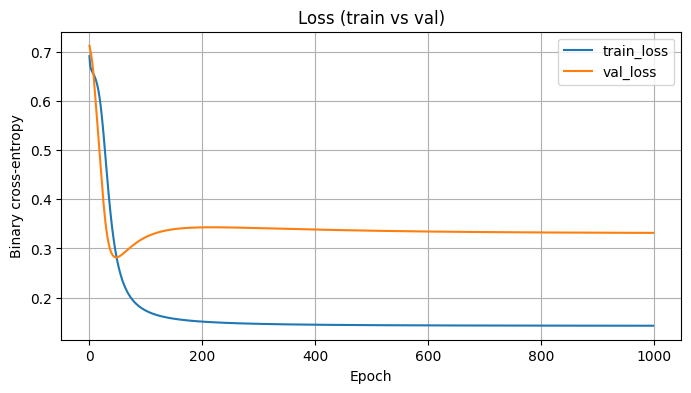

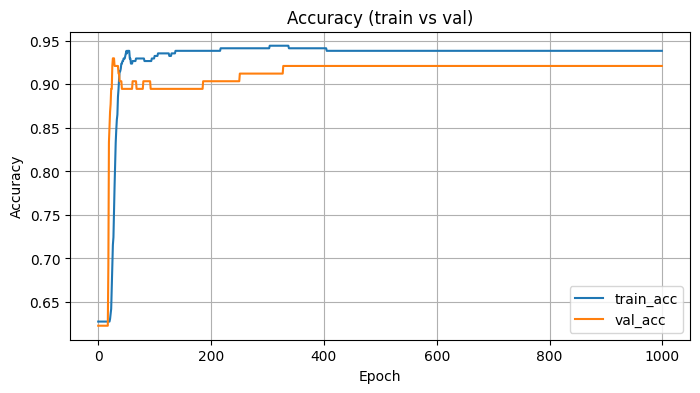

In [155]:
# PLOT TRAINING CURVES

import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(history['loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.title('Loss (train vs val)')
plt.xlabel('Epoch'); plt.ylabel('Binary cross-entropy'); plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(8,4))
plt.plot(history['acc'], label='train_acc')
plt.plot(history['val_acc'], label='val_acc')
plt.title('Accuracy (train vs val)')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True); plt.show()


In [ ]:
# DECISION BOUNDARY PLOT

import numpy as np
import matplotlib.pyplot as plt

# assemble data to determine plotting bounds (use scaled arrays)
try:
    X_all = np.vstack([X_train, X_val, X_test])
except Exception:
    # fallback if val/test not present
    X_all = X_train

x_min, x_max = X_all[:,0].min() - 0.5, X_all[:,0].max() + 0.5
y_min, y_max = X_all[:,1].min() - 0.5, X_all[:,1].max() + 0.5

# grid resolution (reduce to 300 if it's slow)
res = 500
xx, yy = np.meshgrid(np.linspace(x_min, x_max, res), np.linspace(y_min, y_max, res))
grid = np.c_[xx.ravel(), yy.ravel()]

# robust prediction helper — tries common method names used in the notebook
def model_predict_proba(X_grid):
    # expecting X_grid in scaled feature space (same scaling as X_train)
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X_grid)[:, 1]
    if hasattr(model, "predict"):
        p = model.predict(X_grid)
        # handle both probability outputs and class labels
        p = np.asarray(p)
        if p.ndim == 2 and p.shape[1] > 1:
            return p[:, 1]
        # if predict returned classes, convert to float (will be 0/1)
        return p.ravel().astype(float)
    if hasattr(model, "forward"):
        out = model.forward(X_grid)
        # some implementations return (A_out, caches)
        if isinstance(out, (tuple, list)):
            A = out[0]
        else:
            A = out
        return np.asarray(A).ravel()
    raise RuntimeError("Model has no recognizable predict/predict_proba/forward method.")

# compute probabilities on the grid and reshape
Z = model_predict_proba(grid).reshape(xx.shape)

# plot
plt.figure(figsize=(8,6))
# filled regions (light)
plt.contourf(xx, yy, Z, levels=[0.0, 0.5, 1.0], alpha=0.25)
# decision boundary line (0.5)
plt.contour(xx, yy, Z, levels=[0.5], colors='k', linewidths=1)
# training points
plt.scatter(X_train[:,0], X_train[:,1], c=y_train.ravel(), cmap=plt.cm.Set1, edgecolor='k', s=40)
plt.xlabel(features[0] if 'features' in globals() else "Feature 1")
plt.ylabel(features[1] if 'features' in globals() else "Feature 2")
plt.title("Decision boundary (threshold = 0.5)")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()
